# In-depth look at the easiest algorithm - KNN
## Not so easy after all
<img src='images/neigh.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@suju?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Susanne Jutzeler</a>
        on 
        <a href='https://www.pexels.com/photo/closed-doors-3015714/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.impute import SimpleImputer
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Visual display
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)

%config InlineBackend.figure_format = 'retina'

### What Is KNN?

### k-Nearest-Neighbors, under the hood

The first thing you should know about the internals of kNN is that it is a lazy algorithm. In machine learning lingo, it means the algorithm has no or extremely short training phase compared to others. Don't get your hopes up yet because speedy training comes with a big drawback.

Generating predictions will be much slower because of how kNN finds the nearest neighbors. In the short training phase, it memorizes all data points. To make a prediction, the algorithm finds the distance between the new sample and every single data point in the dataset. Then, it takes the *k* smallest distances and classifies the new sample depending on the majority of the vote of its neighbors.
<img src='images/1.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Image by 
        <a href='https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm'>Wikipedia</a>
    </strong>
</figcaption>

To the human eye, labeling the green dot is no problem at all. But, there is no way for the algorithm to find the nearest neighbors without calculating the distance between every single point. 

The distance itself is calculated using one of 3 distance metrics:
- Euclidean distance: the square root of sum of differences between the components of x and y:
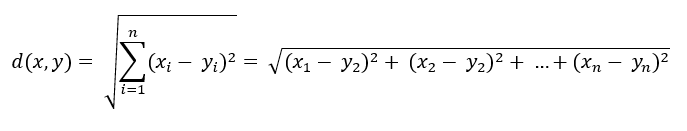
- Manhattan distance: the sum of the absolute values of differences between the components of x and y coordinates:
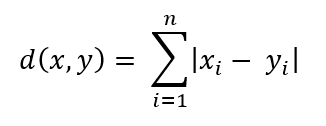
- Minkowski distance is the generalization of the above two techniques. It has a parameter *p* that takes a value of either 1 or 2. When *p=1*, formula becomes manhattan distance, and *p=2* for euclidean:
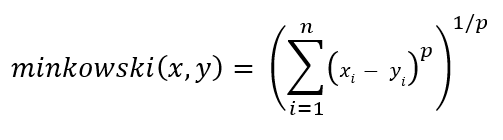

Sorry for the fancy formulas, but you might as well get used to it if you are going to learn machine learning further on.

> The lack of training phase also means that the algorithm does not *generalize*.

Next, kNN is also a *non-parametric* algorithm - it does not have strict requirements on the shape and distribution of your data. Unlike linear regression, which assumes your features and target have a linear relationship, kNN makes no such assumptions. That's why it is considered as one of the easiest models out there and works pretty well out-of-the-box if trained on 'appropriate' data. (And I explain what I mean by 'appropriate' in a later section)

### How to Choose the Value of *k*

I think you have already realized that the results of the algorithm entirely depends on the value of *k*. So, the obvious question is "How do we choose the optimal number for *k*?"

Unfortunately, there is no clear-cut answer. The optimal value changes for every dataset. Your job is to find out the *k* that maximizes your performance metric, i.e. accuracy. However, there are some general trends you can follow to make smart choices for the possible values of *k*.

Firstly, choosing a small value of *k* will lead to overfitting. For example, when *k=1* kNN classifier labels the new sample with the same label as the nearest neighbor. Such classifier will perform terribly at testing. In contrast, choosing a large value will lead to underfitting and will be computationally expensive.

You can think of this in the context of real neighbors. A guy named Jack lives in his hometown all his life and has known his neighbors for a long time. If he moves to a new city, he suddenly becomes a complete stranger and has no way of getting to know his new neighbors quickly. That is, in a sense, overfitting.

In contrast, Jack's son - Jon, is only 6 years old and is too you to know much about their neighbors. When their family moves, Jon neither knows his old neighbors well or his new neighbors. This can be thought of underfitting, an algorithm too dumb to understand the trends in both the training and test sets. 

Now, there is a completely another person - Bruce, who is very friendly, sociable, travels a lot and knows many languages. Wherever he moves he quickly becomes good friends with everyone around him. In this analogy, Bruce's qualities can be thought as the best parameters of an algorithm.

This example might not make any sense to you whatsoever, but everyone has their own version of interpreting of what is overfitting and underfitting. Important thing is that you understand how the performance of kNN changes as you play around with different values of K. 

In practice, you would use tools like `GridSearchCV` to choose the number of neighbors but that is a little out the of the scope of this post. Instead, we will choose the optimal number visually with model complexity curves.

### Classification With KNeighborsClassifier

As I said earlier, for classification problems, the label of a new sample is identified by the majority of the votes in the nearest *k* neighbors. Let's see the algorithm in action using `sklearn`'s `KNeighborsClassifier`:
```python
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
```
We import it from `sklearn.neighbors` along with other helpful functions. All other libraries are imported under standard aliases. 

For the dataset, we will use the [Palmer Archipelago Penguins](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) data from Kaggle. This dataset consists of features of 3 penguins species: Adélie, Gentoo, and Chinstrap. We will build kNN classifier of penguin species by using their body measurements:

In [3]:
penguins = pd.read_csv('data/penguins_size.csv').dropna()
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


https://twitter.com/allison_horst/status/1270046411002753025?s=20

I mentioned that kNN does not make any assumptions about the distribution of data. Let's build our first classifier without any preprocessing. We will only use 3 columns as features: culmen length and depth, flipper length and BMI:

In [29]:
# Create features and target
X = penguins.select_dtypes(exclude=['object'])
y = penguins.species

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Initialize a model with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Fit and predict
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

For simplicity, I chose only numerical columns. Created a test prediction with size 0.25 and fit a classifier with 3 neighbors. Let's calculate its accuracy using `accuracy_score`:

In [30]:
accuracy_score(y_test, predictions)

0.7722772277227723

We get 77% accuracy which is not ideal but a pretty good score for an out-of-the-box model.

### Regression With KNeighborsRegressor

In a regression task, which predicts continuous values (not labels), kNN takes the mean of the nearest *k* neighbors. The regressor is readily-available from `sklearn.neighbors.KNeighborsRegressor`:

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

We import it with `mean_absolute_error` to score its accuracy. This time, we will try to predict Body Mass Index of the penguins using their 3 body measurements (again, only numeric features without preprocessing):

In [40]:
# Create features and target
X = penguins.select_dtypes(exclude=['object']).drop('body_mass_g', axis=1)
y = penguins.body_mass_g

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Initialize kNN
knn = KNeighborsRegressor(n_neighbors=5)

# Fit and predict
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

# Score
mean_absolute_error(y_test, predictions)

282.1782178217822

Setting the number of neighbors to 5 yielded an MAE of 282. For now, we don't really have a way of knowing whether this a good score or not. 